# 역대 타자에 대한 데이터

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bsp
from scipy import stats
import statsmodels.formula.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import requests
import matplotlib.pylab as plt
import xlrd
import xlsxwriter
%matplotlib inline

# 스텟티즈 크롤링

In [2]:
# 받은 인자를 변환 가능하면 float으로 바꿔주는 함수
def num(s):
    try:
        return float(s)
    except ValueError:
        return s

In [3]:
# url에서 선수들의 list를 구합니다.

# 탑 1~100 WAR 상위 선수들에 대한 html
url='http://www.statiz.co.kr/stat_at.php?mid=stat_at&re=0&ys=2017&ye=2017&se=0&te=&tm=&ty=2011&qu=auto&po=0&as=&ae=&hi=&un=&pl=&da=1&o1=TPA&o2=TPA&de=1&lr=0&tr=&cv=&ml=2&sn=100&si=&cn='
r=requests.get(url)
soup=bsp(r.text,'lxml')

lst=[]
for link in soup.findAll('a', href=True): #링크 데이터는 href라는 어트리뷰션이 있습니다.
    if 'player' in link['href']:  # 링크 안에 'player'가 있을 경우 선수의 정보에 대한 링크임을 알 수 있습니다.
        lst.append(link['href'])  

del lst[0]   # 첫번째 줄은 틀만 존재하는 줄이기에 제거합니다.


# 탑 100~200 WAR 상위 선수들에 대한 html
url='http://www.statiz.co.kr/stat_at.php?mid=stat_at&re=0&ys=2017&ye=2017&se=0&te=&tm=&ty=2011&qu=auto&po=0&as=&ae=&hi=&un=&pl=&da=1&o1=TPA&o2=TPA&de=1&lr=0&tr=&cv=&ml=2&sn=100&pa=100&si=&cn='
r=requests.get(url)
soup=bsp(r.text,'lxml')

sublst=[]
for link in soup.findAll('a', href=True)[0:]: # 위와 같은 작업을 다른 url로 반복합니다. 
    if 'player' in link['href']:
        sublst.append(link['href'])
        
del sublst[0]
sublst=list(set(sublst))# 중복되는 항을 제거합니다.

lst+=sublst #얻은 두 리스트를 합쳐 하나의 리스트를 만듭니다.

In [4]:
column1=['urlcode','season','team','age','P','G','PA','AB','R','H','2B','3B','HR','TB','RBI','SB','SC','BB','HBP','IBB','SO','GDP','SAC','SF','AVG','OBP','SLG','wOBA','wRC','WAR','WPA']
column2=['urlcode','year','팀','나이','P','G','타석','타수','득점','안타','2타','3타','홈런','루타','타점','도루','도실','볼넷','사구','고4','삼진','병살','희타','희비','타율','출루','장타','OPS','wOBA','wRC+','WAR*','WPA']

print(len(column1),len(column2))

31 32


In [5]:
# 데이터프레임의 컬럼

datalist=[] #database가 될 list

for i in lst:
    
    url1='http://www.statiz.co.kr/player.php?opt=1&'+ i[11:] # 매 년도별 선수 데이터는 opt=1이라는 항목에 있습니다. i[11:]은 선수 고유번호입니다.
    r=requests.get(url1)
    soup1=bsp(r.text,'lxml')
    
    a=soup1.find('table',class_="table table-striped table-responsive table-condensed no-space table-bordered",style="font-size:;") #table이라는 tag 중에 원하는 테이블을 지칭하는 조건들입니다. 
    b=a.find_all('tr',attrs={'class': None}) # tr은 테이블의 행을 태깅합니다. 각 행을 list로 나눕니다.

    for det in b:
        temp=[i]  #temp는 한 선수의 한 년도에 대한 기록입니다. merge를 위해 urlcode를 list의 앞에 추가합니다.
        for k in det.find_all('span'): # 한 행에서 열별로 데이터를 나누고 for문으로 차례대로 temp에 입력합니다.
            temp.append(num(k.get_text())) # num 함수를 이용해 인자가 숫자형태로 변환 가능할 경우 float으로 바꿔줍니다.
        datalist.append(temp) 

dataf=pd.DataFrame(datalist,columns=column2)  # 리스트들의 리스트를 데이터베이스로 바꿉니다. 

In [9]:
tab=[]
#opt=11은 년도별 선수 연봉과 WAR이 있습니다. 위와 같은 작업을 opt=11로 바꿔 반복합니다. 
#for 문을 2개 돌리는 이유는, 같은 선수여도 두 데이터의 행 크기가 다르기 때문입니다.
for i in lst:  
    url2= 'http://www.statiz.co.kr/player.php?opt=11&'+ i[11:]  
    r=requests.get(url2)
    soup2=bsp(r.text,'lxml')
    name = soup2.find('font', style="font-size:20px;font-weight:bold;").get_text()  # 선수의 이름을 찾습니다.
    table= soup2.find_all(class_="evenrow_stz") + soup2.find_all(class_="oddrow_stz") 
    # 이번 테이블의 행은 특이한 class를 갖는데, evenrow와 oddrow라는 조건으로 빠르게 찾을 수 있습니다.
    for sal in table:
        temp=[name,i] # 기본적으로 선수 이름과 urlcode를 list에 추가합니다.
        for j in sal.findAll('td'):
            temp.append(num(j.get_text()))
        tab.append(temp)
        

datas=pd.DataFrame(tab, columns=['name','urlcode','season','salary','WAR']) # 리스트를 데이터프레임으로 바꿉니다.

In [10]:
# 얻은 두 데이터를 merge 합니다. 공통된 columns는 urlcode와 season입니다. 
merge=pd.merge(dataf,datas, how='inner')
merge.head()

,urlcode,year,팀,나이,P,G,타석,타수,득점,안타,...,장타,OPS,wOBA,wRC+,WAR*,WPA,name,season,salary,WAR
0,player.php?name=%EC%86%90%EC%95%84%EC%84%AD&bi...,2007,롯데,19,RF,4.0,6.0,6.0,2.0,1.0,...,0.333,0.5,0.222,22.2,-0.03,NaN,손아섭,2008.0,,1.172
1,player.php?name=%EC%86%90%EC%95%84%EC%84%AD&bi...,2007,롯데,19,RF,4.0,6.0,6.0,2.0,1.0,...,0.333,0.5,0.222,22.2,-0.03,NaN,손아섭,2010.0,"4,000",2.849
2,player.php?name=%EC%86%90%EC%95%84%EC%84%AD&bi...,2007,롯데,19,RF,4.0,6.0,6.0,2.0,1.0,...,0.333,0.5,0.222,22.2,-0.03,NaN,손아섭,2012.0,"13,000",3.586
3,player.php?name=%EC%86%90%EC%95%84%EC%84%AD&bi...,2007,롯데,19,RF,4.0,6.0,6.0,2.0,1.0,...,0.333,0.5,0.222,22.2,-0.03,NaN,손아섭,2014.0,"40,000",6.852
4,player.php?name=%EC%86%90%EC%95%84%EC%84%AD&bi...,2007,롯데,19,RF,4.0,6.0,6.0,2.0,1.0,...,0.333,0.5,0.222,22.2,-0.03,NaN,손아섭,2016.0,"60,000",5.150


In [11]:
#얻은 데이터를 excel로 출력합니다.
writer=pd.ExcelWriter('스텟티즈마이닝3.xlsx')
merge.to_excel(writer,'Sheet1')
writer.close()

# KBO 크롤링

In [12]:
hitter_data = pd.read_excel('1982_2017_hitter_report.xlsx')
hitter_data.tail()

,URL,season,WAR,AVG,G,PA,AB,R,H,2B,...,XBH,GO,AO,GO/AO,GW RBI,BB/K,P/PA,ISOP,XR,GPA
3415,http://www.koreabaseball.com/Record/Player/Hit...,2016,7.75,0.376,138,618,519,99,195,46,...,79.0,108.0,140.0,0.77,9.0,1,3.94,0.276,136.4,0.372
3416,http://www.koreabaseball.com/Record/Retire/Hit...,2015,7.76,0.343,140,622,528,129,181,35,...,89.0,87.0,103.0,0.84,16.0,0.48,4.05,0.371,144.7,0.375
3417,http://www.koreabaseball.com/Record/Retire/Hit...,2014,8.05,0.356,117,501,418,103,149,36,...,78.0,86.0,79.0,1.09,10.0,0.64,4.11,0.383,120.8,0.391
3418,http://www.koreabaseball.com/Record/Retire/Hit...,2014,0.76,0.286,77,203,175,23,50,8,...,10.0,53.0,32.0,1.66,0.0,0.6,4.08,0.074,23.7,0.257
3419,http://www.koreabaseball.com/Record/Player/Hit...,2015,3.03,0.284,133,491,433,55,123,20,...,34.0,123.0,111.0,1.11,10.0,0.54,4.00,0.141,64.2,0.262


In [13]:
kbo=pd.read_excel('kbo.xlsx') # 규정타석을 구할 때 사용

In [14]:
#규정타석의 반 이상을 채운 역대 타자만 분류

season =[]
game = []
mab = [] #규정타석
for i in kbo['season']:
    season.append(i)
for j in kbo['game']:
    game.append(j)

season_game = {}
for i in range(len(season)):
    season_game[season[i]] = game[i]
    
hitter_data = hitter_data.sort_values('season') 

for i in hitter_data['season']:
    j = int(season_game[i]*3.1)
    mab.append(j)
hitter_data['mab'] = mab
hitter_data[['season','mab']]
hitter_data_mab_half = hitter_data[hitter_data['AB'] >= hitter_data['mab']*0.5]
#hitter_data_mab_half.to_excel('1982_2017_hitter_halfmab.xlsx',sheet_name = 'sheet1')

In [15]:
hitter_data_mab_half.head()

,URL,season,WAR,AVG,G,PA,AB,R,H,2B,...,GO,AO,GO/AO,GW RBI,BB/K,P/PA,ISOP,XR,GPA,mab
0,http://www.koreabaseball.com/Record/Retire/Hit...,1982,5.88,0.412,72,298,250,103,23,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248
35,http://www.koreabaseball.com/Record/Retire/Hit...,1982,1.00,0.252,80,299,274,69,14,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248
36,http://www.koreabaseball.com/Record/Retire/Hit...,1982,0.95,0.261,73,289,261,68,14,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248
37,http://www.koreabaseball.com/Record/Retire/Hit...,1982,0.94,0.23,71,263,235,54,9,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248
38,http://www.koreabaseball.com/Record/Retire/Hit...,1982,0.91,0.24,77,256,229,55,14,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248


In [16]:
birth_lst=[]

for url in hitter_data_mab_half.URL:
    r=requests.get(url)
    soup=bsp(r.text,'html5lib')
    k=soup.find('span',id="cphContents_cphContents_cphContents_playerProfile_lblBirthday") # 은퇴인지, 현역인지에 따라 id가 다르기에 따로 계산합니다.
    if k:
        birth_lst.append(k.text)
    else:
        j=soup.find('span', id="cphContents_cphContents_cphContents_ucRetireInfo_lblBirthday").text
        birth_lst.append(j)

In [17]:
hitter_data_mab_half['birthday']= birth_lst
birth_year=[]
for i in hitter_data_mab_half['birthday']:
        birth_year.append(int(i[0:4]))
hitter_data_mab_half['birth_year'] = birth_year
hitter_data_mab_half_birthday = hitter_data_mab_half
hitter_data_mab_half_birthday.to_excel('1982_2017_hitter_halfmab_birthday.xlsx',sheet_name = 'sheet1')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [18]:
hitter_data_mab_half_birthday['age'] = hitter_data_mab_half_birthday['season'] - hitter_data_mab_half_birthday['birth_year']+1 # 한국 나이로 계산합니다.
hitter_data_mab_half_birthday_age = hitter_data_mab_half_birthday
hitter_data_mab_half_birthday_age.to_excel('1982_2017_hitter_halfmab_birthday_age.xlsx',sheet_name = 'sheet1')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
salaryorretire_list=[]
for url in hitter_data_mab_half_birthday_age.URL:
    r=requests.get(url)
    soup=bsp(r.text,'html5lib')
    k=soup.find('span',id="cphContents_cphContents_cphContents_playerProfile_lblSalary")  #선수의 연봉을 얻는 id입니다. 
    if k: #선수가 현역이 아니면 k= None이 됩니다.
        salaryorretire_list.append(k.text)
    else:
        j= 'retire'
        salaryorretire_list.append(j)

In [20]:
hitter_data_mab_half_birthday_age['retireorsalary']= salaryorretire_list
hitter_data_mab_half_birthday_age.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,URL,season,WAR,AVG,G,PA,AB,R,H,2B,...,BB/K,P/PA,ISOP,XR,GPA,mab,birthday,birth_year,age,retireorsalary
0,http://www.koreabaseball.com/Record/Retire/Hit...,1982,5.88,0.412,72,298,250,103,23,1,...,NaN,NaN,NaN,NaN,NaN,248,1943년 11월 27일,1943,40,retire
35,http://www.koreabaseball.com/Record/Retire/Hit...,1982,1.00,0.252,80,299,274,69,14,2,...,NaN,NaN,NaN,NaN,NaN,248,1955년 10월 04일,1955,28,retire
36,http://www.koreabaseball.com/Record/Retire/Hit...,1982,0.95,0.261,73,289,261,68,14,2,...,NaN,NaN,NaN,NaN,NaN,248,1955년 01월 02일,1955,28,retire
37,http://www.koreabaseball.com/Record/Retire/Hit...,1982,0.94,0.23,71,263,235,54,9,0,...,NaN,NaN,NaN,NaN,NaN,248,1954년 03월 02일,1954,29,retire
38,http://www.koreabaseball.com/Record/Retire/Hit...,1982,0.91,0.24,77,256,229,55,14,1,...,NaN,NaN,NaN,NaN,NaN,248,1955년 12월 18일,1955,28,retire


In [21]:
retire_or_player = []
for i in salaryorretire_list:
    if i == 'retire':
        retire_or_player.append('r')   # r for retire
    else:
        retire_or_player.append('p')   # p for player

hitter_data_mab_half_birthday_age['retire_or_player'] = retire_or_player
hitter_data_mab_half_birthday_age_player = hitter_data_mab_half_birthday_age[hitter_data_mab_half_birthday_age['retire_or_player'] == 'p']
hitter_data_mab_half_birthday_age_player

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,URL,season,WAR,AVG,G,PA,AB,R,H,2B,...,P/PA,ISOP,XR,GPA,mab,birthday,birth_year,age,retireorsalary,retire_or_player
989,http://www.koreabaseball.com/Record/Player/Hit...,1995,2.77,0.285,121,411,365,104,29,1,...,NaN,NaN,NaN,NaN,390,1976년 08월 18일,1976,20,100000만원,p
1061,http://www.koreabaseball.com/Record/Player/Hit...,1996,3.65,0.303,122,504,459,139,32,6,...,NaN,NaN,NaN,NaN,390,1976년 08월 18일,1976,21,100000만원,p
1133,http://www.koreabaseball.com/Record/Player/Hit...,1997,6.78,0.329,126,577,517,170,37,3,...,NaN,NaN,NaN,NaN,390,1976년 08월 18일,1976,22,100000만원,p
1210,http://www.koreabaseball.com/Record/Player/Hit...,1998,6.73,0.306,126,568,477,146,32,2,...,NaN,NaN,NaN,NaN,390,1976년 08월 18일,1976,23,100000만원,p
1227,http://www.koreabaseball.com/Record/Player/Hit...,1998,3.66,0.303,121,465,422,128,27,1,...,NaN,NaN,NaN,NaN,390,1976년 02월 08일,1976,23,75000만원,p
1319,http://www.koreabaseball.com/Record/Player/Hit...,1999,1.42,0.276,107,342,312,86,16,1,...,NaN,NaN,NaN,NaN,409,1976년 02월 08일,1976,24,75000만원,p
1316,http://www.koreabaseball.com/Record/Player/Hit...,1999,1.55,0.292,108,416,366,107,19,1,...,NaN,NaN,NaN,NaN,409,1980년 06월 27일,1980,20,30000만원,p
1280,http://www.koreabaseball.com/Record/Player/Hit...,1999,8.91,0.323,132,614,486,157,33,2,...,NaN,NaN,NaN,NaN,409,1976년 08월 18일,1976,24,100000만원,p
1425,http://www.koreabaseball.com/Record/Player/Hit...,2000,-1.23,0.26,119,499,457,119,21,3,...,NaN,NaN,NaN,NaN,412,1980년 06월 27일,1980,21,30000만원,p
1416,http://www.koreabaseball.com/Record/Player/Hit...,2000,0.22,0.225,108,258,227,51,5,1,...,NaN,NaN,NaN,NaN,412,1975년 05월 25일,1975,26,40000만원,p


In [22]:
Debut_Year=[]
for url in hitter_data_mab_half_birthday_age_player.URL:
    r=requests.get(url)
    soup=bsp(r.text,'html5lib')
    k=soup.find('span',id="cphContents_cphContents_cphContents_playerProfile_lblJoinInfo") #선수의 년도별 팀 이름입니다.
    print(k.text)
    Debut_Year.append(k.text)
        

95삼성
95삼성
95삼성
95삼성
94해태
94해태
99해태
95삼성
99해태
98LG
99쌍방울
95삼성
99쌍방울
94해태
01한화
95삼성
00삼성
01삼성
01롯데
01KIA
01한화
00삼성
01삼성
99해태
95삼성
99쌍방울
94해태
00한화
98LG
02LG
03현대
01KIA
00롯데
02LG
00한화
01삼성
94해태
01한화
95삼성
99쌍방울
99해태
98LG
01KIA
01롯데
98LG
03두산
00롯데
04한화
02삼성
00삼성
99해태
00한화
01삼성
01한화
99쌍방울
02LG
03LG
94해태
04LG
01SK
04롯데
05LG
98LG
01롯데
94해태
99해태
02LG
02삼성
99쌍방울
01롯데
00한화
03두산
01한화
00롯데
00롯데
03LG
05LG
04현대
05롯데
03두산
05SK
01롯데
99해태
05SK
01한화
00한화
01삼성
02LG
03현대
04LG
03현대
01롯데
98LG
02SK
02삼성
03두산
04롯데
99쌍방울
01SK
03LG
02SK
01롯데
01SK
06두산
01두산
01KIA
03현대
04SK
03두산
04현대
98LG
00한화
99해태
03현대
03LG
01한화
03현대
05SK
02LG
05SK
01SK
04LG
94해태
99쌍방울
01삼성
03보스턴
07롯데
01KIA
01SK
98LG
02SK
03LG
04두산
01SK
03두산
02LG
03LG
08KIA
07두산
03LG
03KIA
01삼성
04LG
03현대
04삼성
05SK
03현대
00한화
02삼성
04롯데
05SK
01롯데
01한화
00삼성
08KIA
01SK
99쌍방울
99해태
06한화
00롯데
01두산
98LG
06한화
09두산
03현대
02삼성
01SK
03LG
03LG
07롯데
94해태
09KIA
00롯데
07두산
06두산
09삼성
04롯데
01두산
00한화
06한화
04삼성
03현대
02LG
01KIA
05SK
01롯데
99해태
01SK
01롯데
99쌍방울
04SK
05롯데
01삼성
00삼성
01SK
08KI

In [23]:
hitter_data_mab_half_birthday_age_player['debutyear'] = Debut_Year

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [24]:
hitter_data_mab_half_birthday_age_player

,URL,season,WAR,AVG,G,PA,AB,R,H,2B,...,ISOP,XR,GPA,mab,birthday,birth_year,age,retireorsalary,retire_or_player,debutyear
989,http://www.koreabaseball.com/Record/Player/Hit...,1995,2.77,0.285,121,411,365,104,29,1,...,NaN,NaN,NaN,390,1976년 08월 18일,1976,20,100000만원,p,95삼성
1061,http://www.koreabaseball.com/Record/Player/Hit...,1996,3.65,0.303,122,504,459,139,32,6,...,NaN,NaN,NaN,390,1976년 08월 18일,1976,21,100000만원,p,95삼성
1133,http://www.koreabaseball.com/Record/Player/Hit...,1997,6.78,0.329,126,577,517,170,37,3,...,NaN,NaN,NaN,390,1976년 08월 18일,1976,22,100000만원,p,95삼성
1210,http://www.koreabaseball.com/Record/Player/Hit...,1998,6.73,0.306,126,568,477,146,32,2,...,NaN,NaN,NaN,390,1976년 08월 18일,1976,23,100000만원,p,95삼성
1227,http://www.koreabaseball.com/Record/Player/Hit...,1998,3.66,0.303,121,465,422,128,27,1,...,NaN,NaN,NaN,390,1976년 02월 08일,1976,23,75000만원,p,94해태
1319,http://www.koreabaseball.com/Record/Player/Hit...,1999,1.42,0.276,107,342,312,86,16,1,...,NaN,NaN,NaN,409,1976년 02월 08일,1976,24,75000만원,p,94해태
1316,http://www.koreabaseball.com/Record/Player/Hit...,1999,1.55,0.292,108,416,366,107,19,1,...,NaN,NaN,NaN,409,1980년 06월 27일,1980,20,30000만원,p,99해태
1280,http://www.koreabaseball.com/Record/Player/Hit...,1999,8.91,0.323,132,614,486,157,33,2,...,NaN,NaN,NaN,409,1976년 08월 18일,1976,24,100000만원,p,95삼성
1425,http://www.koreabaseball.com/Record/Player/Hit...,2000,-1.23,0.26,119,499,457,119,21,3,...,NaN,NaN,NaN,412,1980년 06월 27일,1980,21,30000만원,p,99해태
1416,http://www.koreabaseball.com/Record/Player/Hit...,2000,0.22,0.225,108,258,227,51,5,1,...,NaN,NaN,NaN,412,1975년 05월 25일,1975,26,40000만원,p,98LG


In [25]:
startyear_list =[]
season_list = []

for i in hitter_data_mab_half_birthday_age_player['season']:
    i = str(i)
    season_list.append(i)

for i in hitter_data_mab_half_birthday_age_player['debutyear']:
    if int(i[0]) == 9:
        j = str(19)+ i
        startyear_list.append(j[0:4])
    if int(i[0]) != 9:
        j = str(20) + i
        startyear_list.append(j[0:4])


In [26]:
hitter_data_mab_half_birthday_age_player['debutyear'] = startyear_list
hitter_data_mab_half_birthday_age_player = hitter_data_mab_half_birthday_age_player

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [27]:
hitter_data_mab_half_birthday_age_player.to_excel('hitter_data_mab_half_birthday_age_player.xlsx',sheet_name = 'sheet1')

In [28]:
year_list=[]
for i in range(len(hitter_data_mab_half_birthday_age_player['season'])):
    
    j = int(season_list[i]) - int(startyear_list[i]) +1
    year_list.append(j)

In [29]:
hitter_data_mab_half_birthday_age_player['year'] = year_list
hitter_data_mab_half_birthday_age_player_year = hitter_data_mab_half_birthday_age_player

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [30]:
height_weight=[]
for url in hitter_data_mab_half_birthday_age_player_year.URL:
    r=requests.get(url)
    soup=bsp(r.text,'html5lib')
    k=soup.find('span',id="cphContents_cphContents_cphContents_playerProfile_lblHeightWeight") #선수의 키와 나이입니다.
    height_weight.append(k.get_text())
    print(k.text)

183cm/87kg
183cm/87kg
183cm/87kg
183cm/87kg
187cm/95kg
187cm/95kg
182cm/83kg
183cm/87kg
182cm/83kg
183cm/99kg
185cm/90kg
183cm/87kg
185cm/90kg
187cm/95kg
185cm/110kg
183cm/87kg
183cm/94kg
182cm/91kg
194cm/100kg
188cm/84kg
185cm/110kg
183cm/94kg
182cm/91kg
182cm/83kg
183cm/87kg
185cm/90kg
187cm/95kg
183cm/100kg
183cm/99kg
185cm/90kg
183cm/89kg
188cm/84kg
179cm/77kg
185cm/90kg
183cm/100kg
182cm/91kg
187cm/95kg
185cm/110kg
183cm/87kg
185cm/90kg
182cm/83kg
183cm/99kg
190cm/95kg
194cm/100kg
183cm/99kg
172cm/73kg
179cm/77kg
188cm/100kg
180cm/80kg
183cm/94kg
182cm/83kg
183cm/100kg
182cm/91kg
185cm/110kg
185cm/90kg
185cm/90kg
178cm/80kg
187cm/95kg
175cm/70kg
175cm/74kg
185cm/100kg
185cm/90kg
183cm/99kg
187cm/130kg
187cm/95kg
182cm/83kg
185cm/90kg
180cm/80kg
185cm/90kg
194cm/100kg
183cm/100kg
172cm/73kg
185cm/110kg
179cm/77kg
179cm/77kg
178cm/80kg
185cm/90kg
186cm/97kg
182cm/82kg
180cm/84kg
180cm/90kg
187cm/130kg
182cm/83kg
172cm/80kg
185cm/110kg
183cm/100kg
182cm/91kg
185cm/90kg
183cm/89kg
175

181cm/75kg
183cm/89kg
176cm/69kg
181cm/74kg
185cm/98kg
181cm/83kg
178cm/76kg
185cm/90kg
184cm/85kg
184cm/85kg
180cm/80kg
178cm/82kg
178cm/83kg
180cm/73kg
187cm/100kg
184cm/78kg
186cm/92kg
179cm/77kg
186cm/88kg
174cm/84kg
187cm/96kg
182cm/92kg
186cm/97kg
184cm/83kg
178cm/88kg
188cm/100kg
182cm/83kg
176cm/78kg
184cm/84kg
186cm/101kg
183cm/80kg
182cm/82kg
185cm/90kg
180cm/80kg
180cm/80kg
185cm/90kg
183cm/87kg
180cm/88kg
181cm/66kg
179cm/92kg
187cm/130kg
182cm/83kg
179cm/82kg
183cm/75kg
184cm/90kg
180cm/82kg
188cm/89kg
179cm/77kg


In [31]:
height = []

for i in range(len(height_weight)):
    height.append(height_weight[i][:3])

weight = []
weight_end = []

for i in height_weight:
    for k in range(len(i)):
        if i[k] == 'k':
            weight_end.append(k)
    weight.append(i[6:k-1])
hitter_data_mab_half_birthday_age_player_year['height'] = height
hitter_data_mab_half_birthday_age_player_year['weight'] = weight
hitter_data_mab_half_birthday_age_player_year_height_weight = hitter_data_mab_half_birthday_age_player_year

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [32]:
hitter_data_mab_half_birthday_age_player_year_height_weight = hitter_data_mab_half_birthday_age_player_year_height_weight.rename(columns = {'retireorsalary':'salary'})
hitter_data_mab_half_birthday_age_player_year_height_weight
hitter_data_mab_half_birthday_age_player_year_height_weight.to_excel('hitter_data_mab_half_birthday_age_player_year_height_weight.xlsx',sheet_name = 'sheet1')

# 시각화

# For pie chart (age, salary, retired)

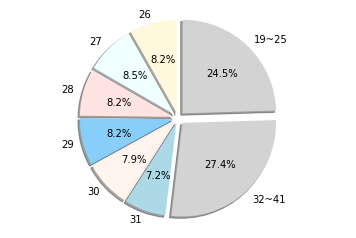

In [33]:
agewar=pd.read_excel('a.xlsx') #규정 타석 반이상으로 줄인 파일
aged=agewar[['age','WAR']]
agedd=aged['WAR'].groupby(aged['age']).describe()
for i in range(19,26):
    agedd = agedd.drop(i,0)
for i in range(32,42):
    agedd = agedd.drop(i,0)
agedd.loc[32]=(759,0,0,0,0,0,0,0)
agedd.loc[0]=(680,0,0,0,0,0,0,0)

fig = plt.figure()
labels = '26','27','28','29','30','31','32~41','19~25'
colors = ['cornsilk', 'azure', 'mistyrose', 'lightskyblue','seashell','lightblue','lightgray','lightgray']
explode = (0.05, 0.05, 0.05, 0.05,0.05,0.05,0.07,0.07)
plt.pie(agedd['count'],explode=explode,labels=labels, colors=colors,autopct='%1.1f%%',shadow=True,startangle=90)
plt.axis('equal')
plt.savefig('pie chart')

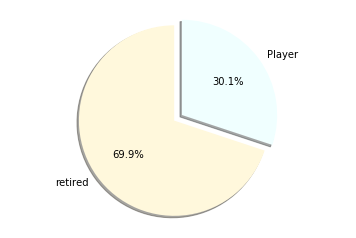

In [34]:
retire=pd.read_excel('1982_2017_hitter_half_money_start.xlsx') #규정타석 반이상 에서 연봉이랑 입단년도랑 retire 표기한 데이터
retired=retire[['salary','start']]
retired.reset_index()

k=0
j=0
s=list(retired['salary'])
for i in range(0,2592):
    if s[i] == 'retire':
        j=j+1
    else:
        k=k+1
m=[j,k]

fig = plt.figure()
labels = 'retired','Player'
colors = ['cornsilk', 'azure']
explode = (0.05, 0.05)
plt.pie(m,explode=explode,labels=labels,colors=colors,autopct='%1.1f%%',shadow=True,startangle=90)
plt.axis('equal')
plt.savefig('pie chart2')

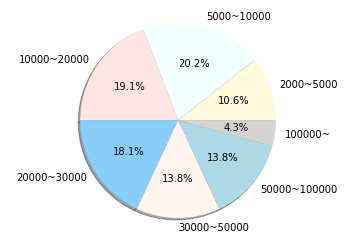

In [35]:
r=list(retired['salary'])
war = pd.read_excel('1982_2017_hitter_half_money_start.xlsx')
season=war[['season','salary']]
sea=season['salary'].groupby(season['season']).get_group(2017)

salary_list=[]
for i in sea:
    salary_list.append(int(i[:-2]))
sea = salary_list
f=[]
for i in range(2700,250001):
    if sea.count(i) !=0:
        f.append([i,sea.count(i)])

t=pd.DataFrame(f)
t.columns=['salary','number']
e = [10,19,18,17,13,13,4]

fig = plt.figure()
labels = '2000~5000','5000~10000','10000~20000','20000~30000','30000~50000','50000~100000','100000~'
colors = ['cornsilk', 'azure', 'mistyrose', 'lightskyblue','seashell','lightblue','lightgray']
plt.pie(e,labels=labels,colors=colors,autopct='%1.1f%%',shadow=True,startangle=0)
plt.axis('equal')
plt.savefig('pie chart3')

# For merging two excel files with deleting same columns¶
Make Team pitcher datasets and Team Offense datasets

In [36]:
workbook = xlrd.open_workbook('Toogoo_1982_2017_eng.xlsx') # 두 파일은 
worksheet = workbook.sheet_by_index(26)
ncols = worksheet.ncols
 
col_val = []
for col_num in range(ncols):
    col_val.append(worksheet.col_values(col_num))
df = pd.DataFrame(col_val)
df.set_index(0, inplace=True)
df=df.T
workbook1 = xlrd.open_workbook('winrate_1991_2017_ver2.xlsx')
worksheet1 = workbook1.sheet_by_index(0)
ncols1 = worksheet1.ncols
 
col_val1 = []
for col_num1 in range(ncols1):
    col_val1.append(worksheet1.col_values(col_num1))
df1 = pd.DataFrame(col_val1)
df1.set_index(0, inplace=True)
df1=df1.T
cols_to_use = df1.columns.difference(df.columns)
dfNew = pd.merge(df, df1[cols_to_use], left_index=True, right_index=True, how='outer')
writer = pd.ExcelWriter('1991.xlsx', engine='xlsxwriter')
dfNew.to_excel(writer, sheet_name='1991')
writer.save()

# For drawing scatter plot between WAR and WPCT

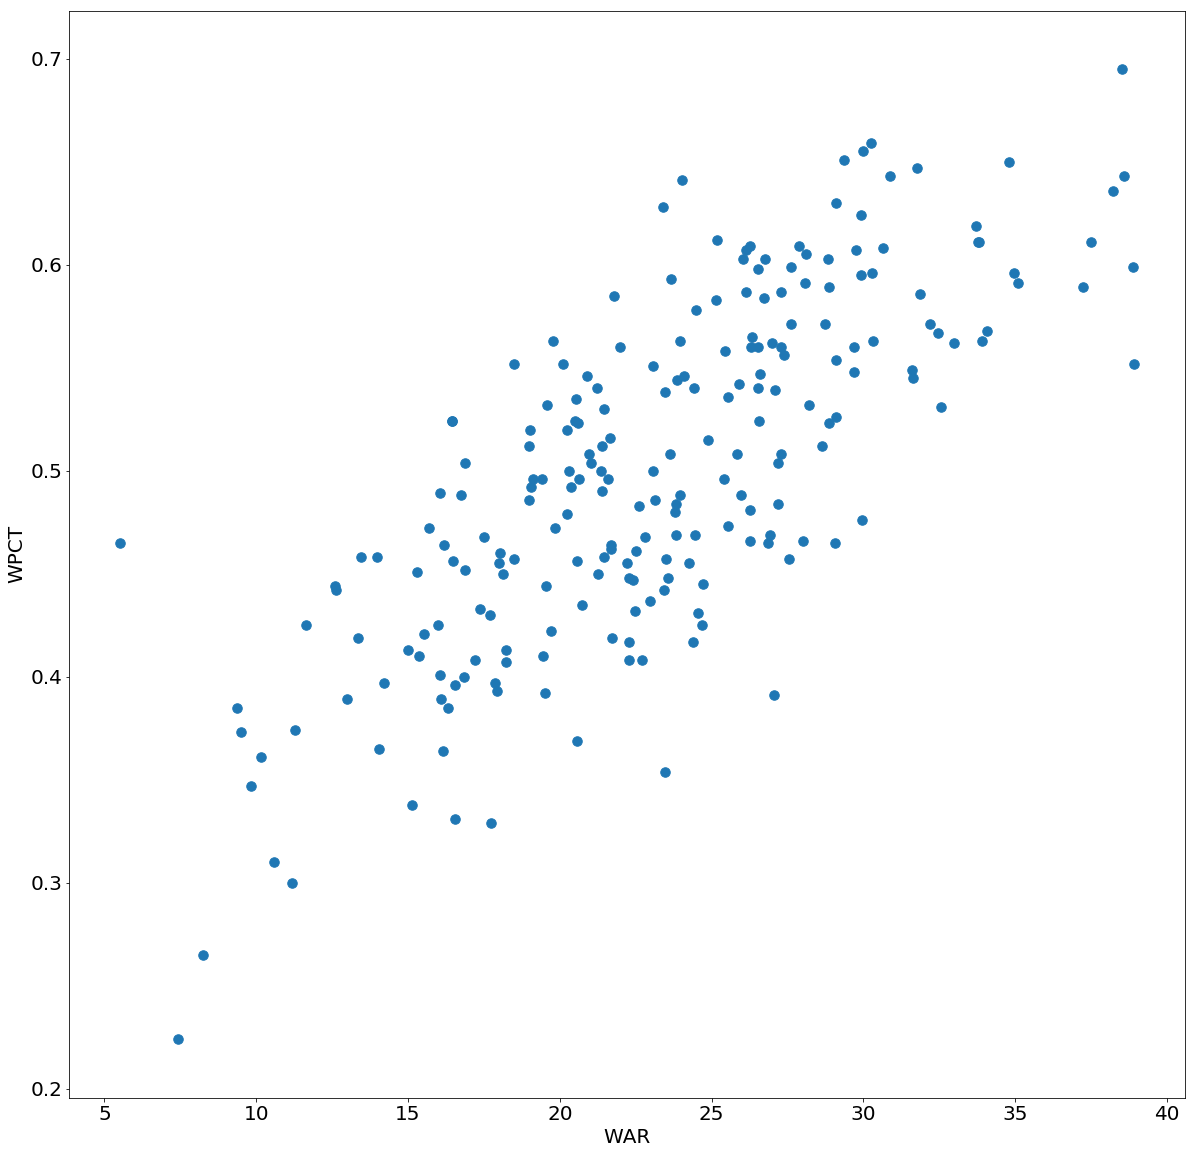

In [37]:
war = pd.read_csv('taja_1991_2017.csv') #타격 타격에 대한 데이터를 정리한 파일
fig = plt.figure(figsize=(20,20))
plt.scatter(war['WAR'],war['WPCT'],s=90)
plt.tick_params(labelsize=20)
plt.xlabel('WAR',fontsize=20)
plt.ylabel('WPCT',fontsize=20)
fig.savefig('taja_scatter.png')

# For drawing aging curve without outlier

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


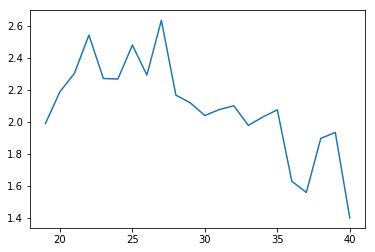

In [38]:
agewar=pd.read_excel('a.xlsx')
a=[]
for j in range(19,41):
    aged = agewar.groupby('age')
    aged1 = aged.get_group(j).describe()
    k=1.5*(aged1.loc['75%','WAR']-aged1.loc['25%','WAR'])
    aged = aged.get_group(j)
    for i in range(0,len(aged.iloc[:,1])):
        if (aged.iloc[i,1] < aged1.loc['25%','WAR']-k) or (aged.iloc[i,1] > aged1.loc['75%','WAR']+k):
            aged.iloc[i,1]=0
    for idx, val in aged.iterrows():
        if val['WAR'] == 0:
            aged.drop(idx, inplace=True)
    a.append(aged['WAR'].mean())
b=range(19,41)
fig = plt.figure()
plt.plot(b,a)
fig.savefig('agingcurve.png')